In [58]:
# Import dependencies and APIs
# QUESTION: What influences a state's ability to control Covid-19?

import pandas as pd
import numpy as np
import requests
import json
from census import Census
from us import states
import matplotlib.pyplot as plt
import scipy.stats as st
# import geoplot as gplt
# import geopandas as gpd
# import geoplot.crs as gcrs
from scipy.stats import linregress

from config import covidkey
from config import censuskey
from config import gkey
c = Census(censuskey, year=2013)
censuskey


'04f514dfbd7422da53425fd0190e7284a2214b9d'

In [4]:
# access census api
census_url=f"api.census.gov/data/2019/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,NAME,STATE&for=region:*&key={censuskey}"

census_url

'api.census.gov/data/2019/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,NAME,STATE&for=region:*&key=04f514dfbd7422da53425fd0190e7284a2214b9d'

In [5]:
# access covid now api
# https://api.covidactnow.org/v2/cbsas.timeseries.csv?apiKey={04f514dfbd7422da53425fd0190e7284a2214b9d}
covid_url = f"https://api.covidactnow.org/v2/states.timeseries.json?apiKey={covidkey}"
covid_url2 = f"https://api.covidactnow.org/v2/states.timeseries.csv?apiKey={covidkey}"
covid_url2

'https://api.covidactnow.org/v2/states.timeseries.csv?apiKey=72b8f0e0bd344e619f281fe9036fff5c'

In [6]:
# import covid state historical data
covid_historic = requests.get(covid_url).json()

In [7]:
covid_historic2 = pd.read_csv("CSVs/states.timeseries.csv")
#covid_historic2.head()

In [8]:
covid_historic_df1 = covid_historic2.loc[:,['date', 'state', 'actuals.cases', 'actuals.deaths', 'actuals.newDeaths', 'actuals.newCases']]
covid_historic_df1 = covid_historic_df1.fillna(0)
#covid_historic_df1.head()

In [9]:
#Import CovidNow data
covidnow_st_df=pd.read_csv("CSVs/Covid_Now_CSVs/states.csv")

#covidnow_st_df.head()

In [10]:
#Import lockdown duration by state
lockdown_df=pd.read_csv("CSVs/LockdownDuration.csv")

#lockdown_df.head()

In [11]:
# Import Oxford Covid data
oxford_df=pd.read_csv("CSVs/OxCGRT_US_latest.csv")

#oxford_df.head()

In [12]:
# Import State Demographics CSV File From the CORGIS Dataset Project (Ryan Whitcomb, 2016)
population_df=pd.read_csv("CSVs/state_demographics.csv")
population_df['State Abbrev'] = ''
population_df.drop(labels=[0],axis=0,inplace=True)
#population_df.head()

In [13]:
# Find the state abbreviation for each state for merging
states_list = []
for x in population_df['State']:
    St_list = states.lookup(x).abbr
    states_list.append(St_list)
        
population_df['state'] = states_list
#population_df.head()

In [14]:
# Filter DF for columns of interest
filtered_pop_df = population_df.loc[:,['state','State','Population.Population per Square Mile']]
#filtered_pop_df.head()

In [15]:
# Merge DF's on state
merged_df = pd.merge(filtered_pop_df, covidnow_st_df, on="state")
#merged_df.head()

In [16]:
# Pull total state population from census api
census_data = c.acs5.get('B01003_001E', {'for': 'state:*'})
census_pd = pd.DataFrame(census_data)
census_pd = census_pd.rename(columns ={'B01003_001E': 'Population'})
#census_pd.head()

In [18]:
# Create an empty column for the state abbreviations
census_pd['State'] = " "

In [17]:
# Replace the state codes with abbreviations
states_list = []
for x in census_pd['state']:
    Z = states.lookup(x).abbr
    states_list.append(Z)

census_pd['State'] = states_list
census_pd.drop(labels=['state'],axis=1,inplace=True)
census_pd = census_pd.rename(columns ={'State': 'state'})
#census_pd.head()

In [18]:
# Merge population data onto the main df
final_df = pd.merge(census_pd,merged_df, on="state")
#final_df.head()

In [80]:
# Find the ratio of the total population for deaths and positive cases
final_df['Death Ratio'] = final_df['actuals.deaths']/final_df['Population']*100
final_df['Positive Ratio'] = final_df['actuals.positiveTests']/final_df['Population']*100
#final_df.head()

In [81]:
# Merge lockdown duration onto the main df
Covid_df = pd.merge(lockdown_df,final_df, on="state")
#Covid_df.describe()

In [82]:
# Filtering out pop density outlier
Covid_df = Covid_df[Covid_df['Population.Population per Square Mile'] < 5000]

The correlation between both factors is -0.06


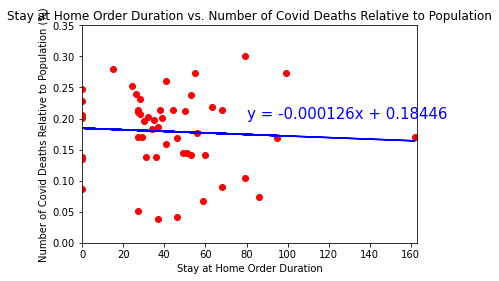

In [119]:

plt.scatter(Covid_df['stay at home length'],Covid_df['Death Ratio'],color='red')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Death Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Stay at Home Order Duration')
plt.ylabel('Number of Covid Deaths Relative to Population (%)')
plt.title('Stay at Home Order Duration vs. Number of Covid Deaths Relative to Population')
plt.xlim(0,163)
plt.ylim(0,0.35)
x_values = Covid_df['stay at home length']
y_values = Covid_df['Death Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,6)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(80,0.20),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Stay at Home Order Duration vs. Number of Covid Deaths Relative to Population.png')
plt.show()

The correlation between both factors is -0.24


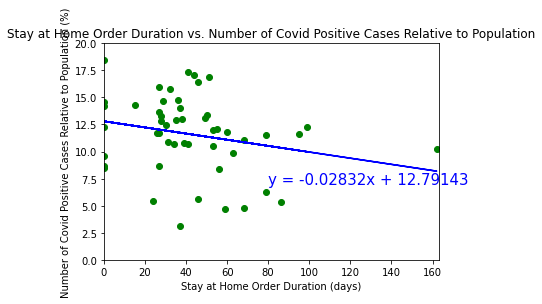

In [120]:

plt.scatter(Covid_df['stay at home length'],Covid_df['Positive Ratio'],color='green')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Stay at Home Order Duration (days)')
plt.ylabel('Number of Covid Positive Cases Relative to Population (%)')
plt.title('Stay at Home Order Duration vs. Number of Covid Positive Cases Relative to Population')
plt.xlim(0,163)
plt.ylim(0,20)
x_values = Covid_df['stay at home length']
y_values = Covid_df['Positive Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(80,7),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Stay at Home Order Duration vs. Number of Covid Positive Cases Relative to Population.png')
plt.show()

The correlation between both factors is 0.44


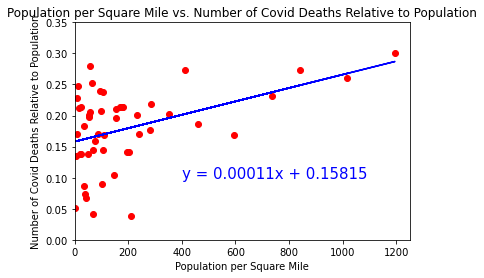

In [121]:

plt.scatter(Covid_df['Population.Population per Square Mile'],Covid_df['Death Ratio'],color='red')
correlation = st.pearsonr(Covid_df['Population.Population per Square Mile'],Covid_df['Death Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Population per Square Mile')
plt.ylabel('Number of Covid Deaths Relative to Population')
plt.title('Population per Square Mile vs. Number of Covid Deaths Relative to Population')
plt.xlim(0,1250)
plt.ylim(0,0.35)
x_values = Covid_df['Population.Population per Square Mile']
y_values = Covid_df['Death Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(400,0.1),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Population per Square Mile vs. Number of Covid Deaths Relative to Population.png')
plt.show()

The correlation between both factors is 0.17


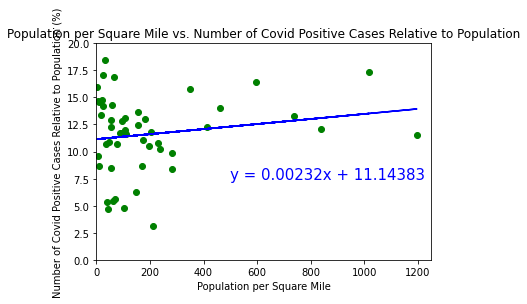

In [122]:

plt.scatter(Covid_df['Population.Population per Square Mile'],Covid_df['Positive Ratio'],color='green')
correlation = st.pearsonr(Covid_df['Population.Population per Square Mile'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Population per Square Mile')
plt.ylabel('Number of Covid Positive Cases Relative to Population (%)')
plt.title('Population per Square Mile vs. Number of Covid Positive Cases Relative to Population')
plt.xlim(0,1250)
plt.ylim(0,20)
x_values = Covid_df['Population.Population per Square Mile']
y_values = Covid_df['Positive Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(500,7.5),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Population per Square Mile vs. Number of Covid Positive Cases Relative to Population.png')
plt.show()

The correlation between both factors is -0.14


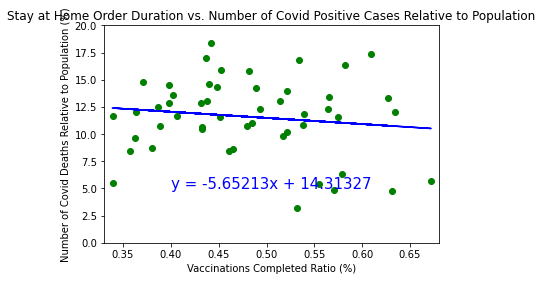

In [123]:

plt.scatter(Covid_df['metrics.vaccinationsCompletedRatio'],Covid_df['Positive Ratio'],color='green')
correlation = st.pearsonr(Covid_df['metrics.vaccinationsCompletedRatio'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Vaccinations Completed Ratio (%)')
plt.ylabel('Number of Covid Deaths Relative to Population (%)')
plt.title('Stay at Home Order Duration vs. Number of Covid Positive Cases Relative to Population')
plt.xlim(0.33,0.68)
plt.ylim(0,20)
x_values = Covid_df['metrics.vaccinationsCompletedRatio']
y_values = Covid_df['Positive Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(.40,5),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Stay at Home Order Duration vs. Number of Covid Positive Cases Relative to Population.png')
plt.show()

The correlation between both factors is -0.06


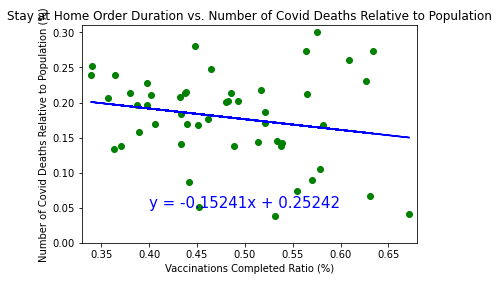

In [124]:

plt.scatter(Covid_df['metrics.vaccinationsCompletedRatio'],Covid_df['Death Ratio'],color='green')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Death Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.xlabel('Vaccinations Completed Ratio (%)')
plt.ylabel('Number of Covid Deaths Relative to Population (%)')
plt.title('Stay at Home Order Duration vs. Number of Covid Deaths Relative to Population')
plt.xlim(0.33,0.68)
plt.ylim(0,0.31)
x_values = Covid_df['metrics.vaccinationsCompletedRatio']
y_values = Covid_df['Death Ratio']
(slope,intercept,rvalue,pvalue,stderr)=linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
plt.annotate(line_eq,(.40,0.05),fontsize=15, color="blue")
plt.plot(x_values,regress_values,"-r",color="blue")
plt.savefig('Stay at Home Order Duration vs. Number of Covid Deaths Relative to Population.png')
plt.show()

In [27]:
#Create a new df which bins the states by population density for bar graphs
#Covid_df.describe()

bins = [0,25,50,75,100,150,250,350,10000]
group_names = ['0-24','25-49','50-74','75-99','100-149','150-249','250-349','350+']
Covid_df['PopDenBins'] = pd.cut(Covid_df['Population.Population per Square Mile'], bins, labels=group_names, include_lowest=True)
Covid_df['PopDenBins'].head()

0      75-99
1       0-24
2      50-74
3      50-74
4    150-249
Name: PopDenBins, dtype: category
Categories (8, object): ['0-24' < '25-49' < '50-74' < '75-99' < '100-149' < '150-249' < '250-349' < '350+']

In [28]:
PopDen_group = Covid_df.groupby('PopDenBins')
PopDen_group['Death Ratio'].mean()

PopDenBins
0-24       0.001702
25-49      0.001098
50-74      0.001889
75-99      0.001936
100-149    0.001493
150-249    0.001742
250-349    0.001979
350+       0.002313
Name: Death Ratio, dtype: float64

In [31]:
#create latitute and longitude values from google api for use in gmaps
derived_lats= [] 
derived_longs=[]
for stateValues in Covid_df['State']:
    target_url = f"https://maps.googleapis.com/maps/api/geocode/json?address={stateValues}&key={gkey}"
    geo_data = requests.get(target_url).json()
    derived_lats.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    derived_longs.append(geo_data["results"][0]["geometry"]["location"]["lng"])

Covid_df['Latitude'] = derived_lats
Covid_df['Longitude'] = derived_longs

In [32]:
#find the Polygon coordinates for states from gplot library
path = gplt.datasets.get_path("contiguous_usa")
contiguous_usa = gpd.read_file(path)

In [33]:
# Renaming columns for merge
contiguous_usa = contiguous_usa.rename(columns = {'state': 'State'})

In [34]:
# Isolating columns of interest
derived_df = contiguous_usa.loc[:,['State','geometry']]

In [35]:
# mergeplot info with 
mergedGeo_df = pd.merge(derived_df, Covid_df, on="State")

In [56]:
#gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))
CovidGeo = gpd.GeoDataFrame(mergedGeo_df, geometry=mergedGeo_df.geometry)
CovidGeo

State                                           geometry state  \
0        Minnesota  POLYGON ((-89.59941 48.01027, -89.48888 48.013...    MN   
1          Montana  POLYGON ((-111.19419 44.56116, -111.29155 44.7...    MT   
2     North Dakota  POLYGON ((-96.60136 46.35136, -96.53891 46.199...    ND   
3            Idaho  POLYGON ((-111.04973 44.48816, -111.05025 42.0...    ID   
4       Washington  POLYGON ((-116.99807 46.33017, -116.90653 46.1...    WA   
5          Arizona  POLYGON ((-109.04523 36.99991, -109.04367 31.3...    AZ   
6       California  POLYGON ((-114.35490 34.46467, -114.16597 34.2...    CA   
7         Colorado  POLYGON ((-102.05017 40.00082, -102.04012 38.4...    CO   
8           Nevada  POLYGON ((-114.03053 36.99410, -114.02363 36.1...    NV   
9       New Mexico  POLYGON ((-103.00161 33.87995, -103.00161 31.9...    NM   
10          Oregon  POLYGON ((-117.02825 42.00002, -117.02825 41.9...    OR   
11            Utah  POLYGON ((-109.05318 41.00199, -109.04523 36.9...    UT   
12         Wyoming  POLYGON ((-111.06719 44.54160, -111.07141 45.0...    WY   
13        Arkansas  POLYGON ((-89.66292 36.02307, -89.67351 35.940...    AR   
14            Iowa  POLYGON ((-90.15664 42.10374, -90.21007 41.834...    IA   
15          Kansas  POLYGON ((-94.60481 39.13986, -94.61538 38.068...    KS   
16        Missouri  POLYGON ((-94.61750 36.99991, -94.62280 36.999...    MO   
17        Nebraska  POLYGON ((-95.45254 40.21514, -95.32288 40.001...    NE   
18        Oklahoma  POLYGON ((-94.62861 36.54059, -94.43017 35.483...    OK   
19    South Dakota  POLYGON ((-96.75427 42.63396, -97.02839 42.717...    SD   
20       Louisiana  POLYGON ((-89.21767 29.29108, -89.40839 29.159...    LA   
21           Texas  POLYGON ((-93.57824 31.21613, -93.48984 31.079...    TX   
22     Connecticut  POLYGON ((-72.87617 41.22056, -73.64789 40.953...    CT   
23   Massachusetts  POLYGON ((-69.88480 41.92276, -69.96521 41.636...    MA   
24   New Hampshire  POLYGON ((-71.50351 45.00780, -71.50509 45.008...    NH   
25    Rhode Island  POLYGON ((-71.14790 41.64759, -71.12038 41.494...    RI   
26         Vermont  POLYGON ((-71.50351 45.00780, -71.62046 44.735...    VT   
27         Alabama  POLYGON ((-85.05442 31.10870, -85.00519 30.990...    AL   
28         Florida  POLYGON ((-80.05654 26.88000, -80.08801 26.205...    FL   
29         Georgia  POLYGON ((-80.86501 32.03316, -81.33629 31.440...    GA   
30     Mississippi  POLYGON ((-88.16696 34.99967, -88.09552 34.805...    MS   
31  South Carolina  POLYGON ((-78.55411 33.86142, -79.06067 33.493...    SC   
32        Illinois  POLYGON ((-90.64082 42.50536, -89.62005 42.505...    IL   
33         Indiana  POLYGON ((-84.80676 41.67774, -84.80993 40.772...    IN   
34        Kentucky  POLYGON ((-81.97254 37.53595, -82.37259 37.238...    KY   
35  North Carolina  POLYGON ((-75.86808 36.55118, -75.72731 35.550...    NC   
36            Ohio  POLYGON ((-82.21066 38.57948, -82.34083 38.440...    OH   
37       Tennessee  POLYGON ((-81.67938 36.58557, -81.70477 36.460...    TN   
38        Virginia  POLYGON ((-78.34562 39.40550, -77.83498 39.134...    VA   
39       Wisconsin  POLYGON ((-86.48156 45.32318, -86.26460 45.226...    WI   
40   West Virginia  POLYGON ((-77.72280 39.32243, -77.83499 39.134...    WV   
41        Delaware  POLYGON ((-75.31987 38.95995, -75.07183 38.782...    DE   
42        Maryland  POLYGON ((-75.04838 38.44877, -75.05673 38.404...    MD   
43      New Jersey  POLYGON ((-73.91280 40.96019, -73.95233 40.750...    NJ   
44        New York  POLYGON ((-74.67903 41.35549, -74.84044 41.426...    NY   
45    Pennsylvania  POLYGON ((-74.89175 40.08179, -75.12882 39.949...    PA   
46           Maine  POLYGON ((-67.13734 45.13745, -66.96466 44.809...    ME   
47        Michigan  POLYGON ((-90.39528 46.61168, -90.35559 46.673...    MI   

    stay at home length  Population  Population.Population per Square Mile  \
0                    51   5347740.0                            

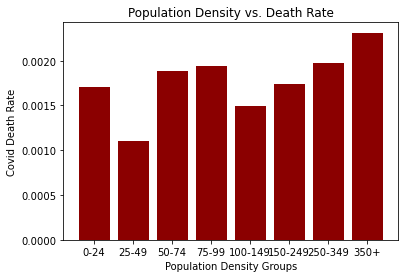

In [126]:
# Bar graph showing population density vs death rate
plt.bar(group_names, PopDen_group['Death Ratio'].mean(),color=("darkred"))
plt.title("Population Density vs. Death Rate")
plt.xlabel("Population Density Groups")
plt.ylabel("Covid Death Rate")
plt.savefig('Population Density vs. Death Rate BAR.png')
plt.show()

<GeoAxesSubplot:>

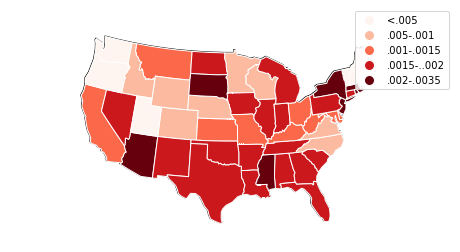

In [57]:
ax = gplt.polyplot(CovidGeo, projection=gcrs.AlbersEqualArea())
gplt.choropleth(
  CovidGeo,
  hue="Death Ratio",
  edgecolor="white",
  linewidth=1,
  cmap="Reds",
  legend=True,
  scheme="FisherJenks",
  legend_labels=[
    "<.005", ".005-.001", ".001-.0015",
    ".0015-..002",".002-.0035"
  ],
  projection=gcrs.AlbersEqualArea(),
  ax=ax
)
plt.savefig('Population Density vs. Death Rate GEO.png')

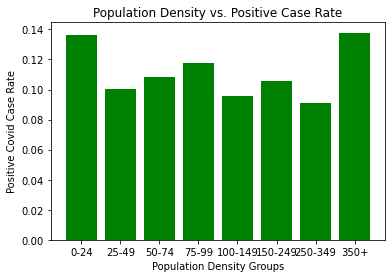

In [125]:
# Bar graph showing population density 
plt.bar(group_names, PopDen_group['Positive Ratio'].mean(),color=("green"))
plt.title("Population Density vs. Positive Case Rate")
plt.xlabel("Population Density Groups")
plt.ylabel("Positive Covid Case Rate")
plt.savefig('Population Density vs. Positive Case Rate BAR.png')
plt.show()

<GeoAxesSubplot:>

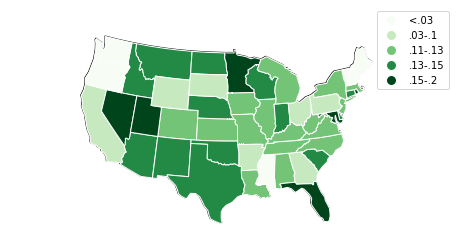

In [39]:
ax = gplt.polyplot(CovidGeo, projection=gcrs.AlbersEqualArea())
gplt.choropleth(
  CovidGeo,
  hue="Positive Ratio",
  edgecolor="white",
  linewidth=1,
  cmap="Greens",
  legend=True,
  scheme="FisherJenks",
  legend_labels=[
    "<.03", ".03-.1", ".11-.13",
    ".13-.15",".15-.2"
  ],
  projection=gcrs.AlbersEqualArea(),
  ax=ax
)
plt.savefig('Population Density vs. Positive Case Rate GEO.png')

In [31]:
#plt.bar(group_names, PopDen_group['stay at home length'].mean())

In [34]:
# Merging state pop data into historic data
covid_historic_df = pd.merge(census_pd, covid_historic_df1, on='state')
# covid_historic_df.head()

In [35]:
# Calculating ratios in relation to the population
covid_historic_df['%cases'] = covid_historic_df['actuals.cases']/covid_historic_df['Population']
covid_historic_df['%deaths'] = covid_historic_df['actuals.deaths']/covid_historic_df['Population']
covid_historic_df['%newCases'] = covid_historic_df['actuals.newCases']/covid_historic_df['Population']
covid_historic_df['%newDeaths'] = covid_historic_df['actuals.newDeaths']/covid_historic_df['Population']
#covid_historic_df.head()

In [36]:
# Making new DFs for each state's historic data
Alabama = covid_historic_df[covid_historic_df['state'] == 'AL']
Alaska = covid_historic_df[covid_historic_df['state'] == 'AK']
Arizona =  covid_historic_df[covid_historic_df['state'] == 'AZ']
Arkansas = covid_historic_df[covid_historic_df['state'] == 'AR']
California= covid_historic_df[covid_historic_df['state'] == 'CA']
Colorado= covid_historic_df[covid_historic_df['state'] == 'CO']
Connecticut= covid_historic_df[covid_historic_df['state'] == 'CT']
Delaware= covid_historic_df[covid_historic_df['state'] == 'DE']
Florida= covid_historic_df[covid_historic_df['state'] == 'FL']
Georgia= covid_historic_df[covid_historic_df['state'] == 'GA']
Hawaii= covid_historic_df[covid_historic_df['state'] == 'HI']
Idaho= covid_historic_df[covid_historic_df['state'] == 'ID']
Illinois= covid_historic_df[covid_historic_df['state'] == 'IL']
Indiana= covid_historic_df[covid_historic_df['state'] == 'IN']
Iowa= covid_historic_df[covid_historic_df['state'] == 'IA']
Kansas= covid_historic_df[covid_historic_df['state'] == 'KS']
Kentucky= covid_historic_df[covid_historic_df['state'] == 'KY']
Louisiana= covid_historic_df[covid_historic_df['state'] == 'LA']
Maine= covid_historic_df[covid_historic_df['state'] == 'ME']
Maryland= covid_historic_df[covid_historic_df['state'] == 'MD']
Massachusetts= covid_historic_df[covid_historic_df['state'] == 'MA']
Michigan= covid_historic_df[covid_historic_df['state'] == 'MI']
Minnesota= covid_historic_df[covid_historic_df['state'] == 'MN']
Mississippi= covid_historic_df[covid_historic_df['state'] == 'MS']
Missouri= covid_historic_df[covid_historic_df['state'] == 'MO']
Montana= covid_historic_df[covid_historic_df['state'] == 'MT']
Nebraska= covid_historic_df[covid_historic_df['state'] == 'NE']
Nevada= covid_historic_df[covid_historic_df['state'] == 'NV']
NewHampshire= covid_historic_df[covid_historic_df['state'] == 'NH']
NewJersey= covid_historic_df[covid_historic_df['state'] == 'NJ']
NewMexico= covid_historic_df[covid_historic_df['state'] == 'NM']
NewYork= covid_historic_df[covid_historic_df['state'] == 'NY']
NorthCarolina= covid_historic_df[covid_historic_df['state'] == 'NC']
NorthDakota= covid_historic_df[covid_historic_df['state'] == 'ND']
Ohio= covid_historic_df[covid_historic_df['state'] == 'OH']
Oklahoma= covid_historic_df[covid_historic_df['state'] == 'OK']
Oregon= covid_historic_df[covid_historic_df['state'] == 'OR']
Pennsylvania= covid_historic_df[covid_historic_df['state'] == 'PA']
RhodeIsland= covid_historic_df[covid_historic_df['state'] == 'RI']
SouthCarolina= covid_historic_df[covid_historic_df['state'] == 'SC']
SouthDakota= covid_historic_df[covid_historic_df['state'] == 'SD']
Tennessee= covid_historic_df[covid_historic_df['state'] == 'TN']
Texas= covid_historic_df[covid_historic_df['state'] == 'TX']
Utah= covid_historic_df[covid_historic_df['state'] == 'UT']
Vermont= covid_historic_df[covid_historic_df['state'] == 'VT']
Virginia= covid_historic_df[covid_historic_df['state'] == 'VA']
Washington= covid_historic_df[covid_historic_df['state'] == 'WA']
WestVirginia= covid_historic_df[covid_historic_df['state'] == 'WV']
Wisconsin= covid_historic_df[covid_historic_df['state'] == 'WI']
Wyoming= covid_historic_df[covid_historic_df['state'] == 'WY']


In [37]:
# List of all state df's
StateDF_list = [Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,
               Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,NewHampshire,NewJersey,NewMexico,NewYork,
               NorthCarolina,NorthDakota,Ohio,Oklahoma,Oregon,Pennsylvania,RhodeIsland,SouthCarolina,SouthDakota,Tennessee,Wisconsin,Wyoming]


In [38]:
# ANOVA to test if any states are significantly different from the others
st.f_oneway(Alabama['%newCases'], Alaska['%newCases'], Arizona['%newCases'], Arkansas['%newCases'], California['%newCases'], Colorado['%newCases'],
              Connecticut['%newCases'], Delaware['%newCases'], Florida['%newCases'], Georgia['%newCases'], Hawaii['%newCases'], Idaho['%newCases'],
              Illinois['%newCases'], Indiana['%newCases'], Iowa['%newCases'], Kansas['%newCases'], Kentucky['%newCases'], Louisiana['%newCases'], 
              Maine['%newCases'], Maryland['%newCases'], Massachusetts['%newCases'], Michigan['%newCases'], Minnesota['%newCases'], Mississippi['%newCases'],
              Missouri['%newCases'], Montana['%newCases'], Nebraska['%newCases'], Nevada['%newCases'], NewHampshire['%newCases'], NewJersey['%newCases'],
              NewMexico['%newCases'], NewYork['%newCases'], NorthCarolina['%newCases'], NorthDakota['%newCases'], Ohio['%newCases'], Oklahoma['%newCases'],
              Oregon['%newCases'], Pennsylvania['%newCases'], RhodeIsland['%newCases'], SouthCarolina['%newCases'], SouthDakota['%newCases'], Tennessee['%newCases'],
              Texas['%newCases'], Utah['%newCases'], Vermont['%newCases'], Virginia['%newCases'], Washington['%newCases'], WestVirginia['%newCases'],
              Wisconsin['%newCases'], Wyoming['%newCases'])

F_onewayResult(statistic=18.7931430073652, pvalue=4.413798227967415e-158)

In [40]:
# for looped 1 sample t-test to isolate significant states for each variable of interest
NC_pvalues = []
ND_pvalues = []
C_pvalues = []
D_pvalues = []
LD_pvalues = []
for state in StateDF_list:
    t_test1 = st.ttest_1samp(state['%newCases'], covid_historic_df['%newCases'].mean())
    NC_pvalues.append(t_test1.pvalue)
    t_test2 = st.ttest_1samp(state['%newDeaths'], covid_historic_df['%newDeaths'].mean())
    ND_pvalues.append(t_test2.pvalue)
    t_test3 = st.ttest_1samp(state['%cases'], covid_historic_df['%cases'].mean())
    C_pvalues.append(t_test3.pvalue)
    t_test4 = st.ttest_1samp(state['%deaths'], covid_historic_df['%deaths'].mean())
    D_pvalues.append(t_test4.pvalue)


State_list = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana',
               'Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','NewHampshire','NewJersey','NewMexico','NewYork',
               'NorthCarolina','NorthDakota','Ohio','Oklahoma','Oregon','Pennsylvania','RhodeIsland','SouthCarolina','SouthDakota','Tennessee','Wisconsin','Wyoming']

#Creating dataframes with each state's pvalues and filtering out values less than 0.05
NCt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': NC_pvalues})
NDt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': ND_pvalues})
Ct_test_df = pd.DataFrame(data={'State': State_list,'pvalue': C_pvalues})
Dt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': D_pvalues})
LDt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': D_pvalues})

NCsignificant_df = NCt_test_df[NCt_test_df['pvalue'] < 0.05]
NDsignificant_df = NDt_test_df[NDt_test_df['pvalue'] < 0.05]
Csignificant_df = Ct_test_df[Ct_test_df['pvalue'] < 0.05]
Dsignificant_df = Dt_test_df[Dt_test_df['pvalue'] < 0.05]
LDsignificant_df = LDt_test_df[LDt_test_df['pvalue'] < 0.05]

#Sorting to make easier to decipher
NCsignificant_df = NCsignificant_df.sort_values(by=['pvalue'])
NDsignificant_df = NDsignificant_df.sort_values(by=['pvalue'])
Csignificant_df = Csignificant_df.sort_values(by=['pvalue'])
Dsignificant_df = Dsignificant_df.sort_values(by=['pvalue'])
LDsignificant_df = LDsignificant_df.sort_values(by=['pvalue'])

In [41]:
# Identifying most significantly different states
NCsignificant_df.head()
NDsignificant_df.head()
Csignificant_df.head()
Dsignificant_df.head()

State         pvalue
10   Hawaii   0.000000e+00
1    Alaska  1.890496e-286
18    Maine  1.248701e-220
36   Oregon  3.867431e-188
31  NewYork  1.089807e-119

(0.0, 0.004)

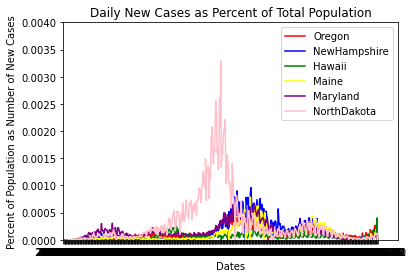

In [42]:
# Line plot showing number of new cases relative to population each day
plt.plot(Oregon['date'], Oregon['%newCases'], color='red', label='Oregon')
plt.plot(NewHampshire['date'], NewHampshire['%newCases'], color='blue', label='NewHampshire')
plt.plot(Hawaii['date'], Hawaii['%newCases'], color='green', label='Hawaii')
plt.plot(Maine['date'], Maine['%newCases'], color='yellow', label='Maine')
plt.plot(Maryland['date'], Maryland['%newCases'], color='purple', label='Maryland')

plt.plot(NorthDakota['date'], NorthDakota['%newCases'], color='pink', label='NorthDakota')

plt.legend()
plt.title('Daily New Cases as Percent of Total Population')
plt.xlabel('Dates')
plt.ylabel('Percent of Population as Number of New Cases')
plt.xlim(0,553)
plt.ylim(0,0.0040)
plt.savefig('Daily New Cases as Percent of Total Population.png')

(0.0, 6e-05)

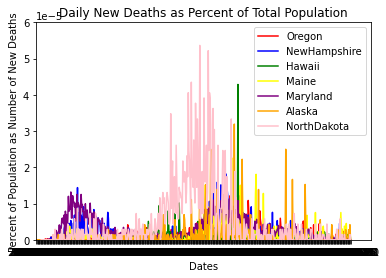

In [43]:
# Line plot showing number of deaths relative to population each day
plt.plot(Oregon['date'], Oregon['%newDeaths'], color='red', label='Oregon')
plt.plot(NewHampshire['date'], NewHampshire['%newDeaths'], color='blue', label='NewHampshire')
plt.plot(Hawaii['date'], Hawaii['%newDeaths'], color='green', label='Hawaii')
plt.plot(Maine['date'], Maine['%newDeaths'], color='yellow', label='Maine')
plt.plot(Maryland['date'], Maryland['%newDeaths'], color='purple', label='Maryland')
plt.plot(Alaska['date'], Alaska['%newDeaths'], color='Orange', label='Alaska')
plt.plot(NorthDakota['date'], NorthDakota['%newDeaths'], color='pink', label='NorthDakota')

plt.legend()
plt.title('Daily New Deaths as Percent of Total Population')
plt.xlabel('Dates')
plt.ylabel('Percent of Population as Number of New Deaths')
plt.xlim(0,553)
plt.ylim(0,0.00006)
plt.savefig('Daily New Deaths as Percent of Total Population.png')

In [ ]:

lockdown_df
LD_pvalues = []
for state in lockdown_df['state']:
    t_test5 = st.ttest_1samp(lockdown_df['stay at home length'], lockdown_df['stay at home length'].mean())
    LD_pvalues.append(t_test5.pvalue)